# Generate VIIRS points

**Name:** Asaf Vanunu  
**Date:** July 31, 2024  
**step:** 1

## Description
This script takes VIIRS fire product and geolocation files and create VIIRS shapefile points


* Import libraries

In [1]:
import GOES_VIIRS_tools
import os
import pandas as pd
import xarray as xr
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

* Set path

In [2]:
VIIRS_fire_product_dir = "F:\\VIIRS_data\\VIIRS_fire"
VIIRS_geolocation_dir = "F:\\VIIRS_data\\VIIRS_GEO"

* Create a file list for the fire and geolocation products

In [3]:
## Get the list of VIIRS fire and geolocation files
VIIRS_fire_files = [os.path.join(VIIRS_fire_product_dir, fire_file) for fire_file in os.listdir(VIIRS_fire_product_dir) if fire_file.endswith("nc")]
VIIRS_geolocation_files = [os.path.join(VIIRS_geolocation_dir, geo_file) for geo_file in os.listdir(VIIRS_geolocation_dir) if geo_file.endswith("nc")]
print(VIIRS_fire_files[0]) 
print(VIIRS_geolocation_files[0])

F:\VIIRS_data\VIIRS_fire\VNP14IMG.A2022182.0906.001.2022183034226.nc
F:\VIIRS_data\VIIRS_GEO\VNP03IMG.A2022182.0906.002.2022182155401.nc


- Now we need to create a matching list of VIIRS fire files to VIIRS geolocation files
- We will start by creating a function the filter matching VIIRS 

In [6]:
def get_unique_id_from_VIIRS_file(VIIRS_file):
    """This function extracts the unique ID from the VIIRS file name. This is for example A2022182.0906

    Args:
        VIIRS_file (string): The VIIRS file name
    """
    VIIRS_file_split = VIIRS_file.split("\\") ## Split the file path
    VIIRS_file_name = VIIRS_file_split[-1] ## Get the file name
    VIIRS_file_name_split = VIIRS_file_name.split(".") ## Split the file name
    VIIRS_unique_id = VIIRS_file_name_split[1] ## Get the unique ID
    VIIRS_unique_time = VIIRS_file_name_split[2] ## Get the unique time
    
    out_string = f"{VIIRS_unique_id}.{VIIRS_unique_time}" ## Create the output string
    return out_string
    

In [7]:
print(get_unique_id_from_VIIRS_file(VIIRS_fire_files[0]))
print(get_unique_id_from_VIIRS_file(VIIRS_geolocation_files[0]))

A2022182.0906
A2022182.0906


* Now we will create the matching lists

In [8]:
matching_VIIRS_fires = [] ## List to store the matching VIIRS fire files
matching_VIIRS_geolocations = [] ## List to store the matching VIIRS geolocation files
geo_files_unique_ids = list(map(get_unique_id_from_VIIRS_file, VIIRS_geolocation_files)) ## Get the unique IDs of the geolocation files

for i in range(len(VIIRS_fire_files)): ## Loop through the VIIRS fire files
    VIIRS_fire_unique_id = get_unique_id_from_VIIRS_file(VIIRS_fire_files[i]) ## Get the unique ID of the VIIRS fire file
    VIIRS_fire_file_condition = np.isin(VIIRS_fire_unique_id, geo_files_unique_ids) ## Check if the unique ID is in the list of unique IDs
    if VIIRS_fire_file_condition: ## If the unique ID is in the list of unique IDs
        matching_VIIRS_fires.append(VIIRS_fire_files[i]) ## Append the matching VIIRS fire file
        matching_VIIRS_geolocations.append(VIIRS_geolocation_files[geo_files_unique_ids.index(VIIRS_fire_unique_id)]) ## Append the matching VIIRS geolocation file

* Now we will see if the two lists are matching

In [9]:
con_list = [] ## List to store the conditions
if len(matching_VIIRS_fires) == len(matching_VIIRS_geolocations): ## Check if the number of matching VIIRS fire and geolocation files is the same
    for i in range(len(matching_VIIRS_fires)): ## Loop through the matching VIIRS fire and geolocation files
        unique_fire_id = get_unique_id_from_VIIRS_file(matching_VIIRS_fires[i]) ## Get the unique ID of the VIIRS fire file
        unique_geo_id = get_unique_id_from_VIIRS_file(matching_VIIRS_geolocations[i]) ## Get the unique ID of the VIIRS geolocation file
        con_list.append(unique_fire_id == unique_geo_id) ## Append the condition to the list
else: ## If the number of matching VIIRS fire and geolocation files is not the same
    print("The number of matching VIIRS fire and geolocation files is not the same. This is an error.")
    
if np.all(con_list): ## Check if all the conditions are true
    print("All the matching VIIRS fire and geolocation files have the same unique ID.")
else:
    print("Not all the matching VIIRS fire and geolocation files have the same unique ID.")
        

All the matching VIIRS fire and geolocation files have the same unique ID.


* Now we can create pandas dataframe for the files locations

In [10]:
matching_VIIRS_df = pd.DataFrame({"VIIRS_fire_files": matching_VIIRS_fires, "VIIRS_geolocation_files": matching_VIIRS_geolocations}) ## Create a dataframe of the matching VIIRS fire and geolocation files
matching_VIIRS_df[:5]

,VIIRS_fire_files,VIIRS_geolocation_files
0,F:\VIIRS_data\VIIRS_fire\VNP14IMG.A2022182.090...,F:\VIIRS_data\VIIRS_GEO\VNP03IMG.A2022182.0906...
1,F:\VIIRS_data\VIIRS_fire\VNP14IMG.A2022182.091...,F:\VIIRS_data\VIIRS_GEO\VNP03IMG.A2022182.0912...
2,F:\VIIRS_data\VIIRS_fire\VNP14IMG.A2022182.104...,F:\VIIRS_data\VIIRS_GEO\VNP03IMG.A2022182.1048...
3,F:\VIIRS_data\VIIRS_fire\VNP14IMG.A2022182.105...,F:\VIIRS_data\VIIRS_GEO\VNP03IMG.A2022182.1054...
4,F:\VIIRS_data\VIIRS_fire\VNP14IMG.A2022182.185...,F:\VIIRS_data\VIIRS_GEO\VNP03IMG.A2022182.1854...


* Now we will generate VIIRS points

In [11]:
AOI_dir = None ## Here we can choose whether to use the AOI or not for cropping the points

In [ ]:
point_list = [] ## List to store the points
for i in range(len(matching_VIIRS_fires)): ## Loop through the matching VIIRS fire and geolocation files
    ## Generate the VIIRS points
    VIIRS_temp_points = GOES_VIIRS_tools.generate_VIIRS_points(VIIRS_fire_path=matching_VIIRS_fires[i],
                                       VIIRS_GEO_path=matching_VIIRS_geolocations[i],
                                       AOI_path=AOI_dir) ## Generate the VIIRS points 
    point_list.append(VIIRS_temp_points) ## Append the points to the list

* Now we can plot it to see if it works

In [43]:
## Load world data
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

C:\Users\asaf_rs\AppData\Local\Temp\ipykernel_16332\2582800940.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


In [44]:
## Concatenate the points
gdf_points = pd.concat(point_list) ## Concatenate the points

In [38]:
print(f"the number of points is: {len(gdf_points)}") ## Print the length of the geodataframe

the number of points is: 104831


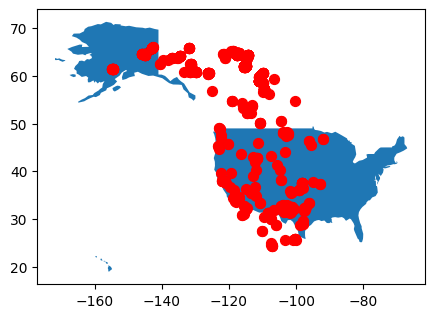

In [45]:
## Plot the points
ax = world[world["name"] == "United States of America"].plot(figsize=(5, 5))
gdf_points.plot(ax=ax, color='red', markersize=50)
plt.show()

* Now we can export our points

In [ ]:
out_pnt_dir = "F:\\try" ## Output directory
## Check if the output directory exists
if os.path.isdir(out_pnt_dir) == False: ## If the output directory does not exist
    os.mkdir(out_pnt_dir) ## Create the output directory
else: ## If the output directory exists
    print("Folder exists")

In [ ]:
gdf_points.to_file("{}\\VIIRS_pnt.shp".format(out_pnt_dir)) ## Save the points to a shapefile